In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


try:
    import jieba
except ModuleNotFoundError:
    !pip install jieba
import jieba
import jieba.analyse


try:
    from opencc import OpenCC
except ModuleNotFoundError:
    !pip install opencc-python-reimplemented
from opencc import OpenCC


try:
    import gensim
except ModuleNotFoundError:
    !pip install gensim
import gensim
from gensim import utils
from gensim import corpora,models


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv1D,Activation,MaxPooling1D,
                                     Dense,BatchNormalization,Flatten,
                                     Input,GlobalMaxPooling1D,GlobalMaxPooling2D,
                                     Conv2D,Add)
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

### Loading Training Datasets

In [2]:
%%time
""" 簡體轉換成繁體  """
convertor = OpenCC('s2tw')

path_folder = 'path of training datas'
jieba.set_dictionary('path of jieba dictionary')

with open('path of stopping words','r',encoding='utf-8') as file:
    stopWords = file.read().split('\n')

TEXT = []
for folder in os.listdir(path_folder):
    path_subfolder = path_folder + '\\' + folder
    text = []
    for file in os.listdir(path_subfolder):
        path_file = path_subfolder + '\\' + file
        text.append(
            convertor.convert(
                re.sub('http:[/\w.]*','',re.sub('\s','',open(path_file,encoding='utf-8').read()))
            )
        )
    TEXT.append(text)

Wall time: 41.8 s


## Data Prepocessing

In [4]:
%%time
"""
## 提取 top-10 的 tf-idf 結果
"""
Jieba_Result = []
for n_category in range(len(TEXT)):
    jieba_result = []
    for n_files in range(len(TEXT[n_category])):
        result = list(jieba.cut_for_search(TEXT[n_category][n_files]))
        result = jieba.analyse.extract_tags(re.sub('\d*','',''.join(result)),topK = 10)
        jieba_result.append([t for t in result if t not in stopWords])
    Jieba_Result.append(jieba_result)
Jieba_Result = sum(Jieba_Result,[])

dictionary = corpora.Dictionary(Jieba_Result)
corpus = [dictionary.doc2bow(text) for text in Jieba_Result]
model = models.TfidfModel(corpus)
corpus_tfidf = [text for text in model[corpus]]

X = gensim.matutils.corpus2dense(corpus_tfidf,num_terms=len(dictionary.token2id)).T

y = [[category]*len(TEXT[idx]) for idx,category in enumerate(os.listdir(path_folder))]
y = sum(y,[])

le = LabelEncoder()
y_le = le.fit_transform(np.reshape(y,(-1,1)))

Building prefix dict from C:\Users\CHUSHENGTAN\Desktop\dict.txt.big.txt ...
Loading model from cache C:\Users\CHUSHE~1\AppData\Local\Temp\jieba.u5e9331e68a82b19098f5fc63918823d8.cache
Loading model cost 1.105 seconds.
Prefix dict has been built successfully.


Wall time: 1min 6s


In [9]:
x_train,x_test,y_train,y_test = train_test_split(X,y_le,test_size = 0.25 , stratify = y_le)
x_valid,x_test,y_valid,y_test = train_test_split(x_train,y_train,test_size = 0.25 , stratify = y_train)
print(len(x_train),len(x_valid),len(x_test))

n_category = len(os.listdir(path_folder))

x_train_ = tf.expand_dims(tf.convert_to_tensor(x_train),axis=1)
x_valid_ = tf.expand_dims(tf.convert_to_tensor(x_valid),axis=1)
x_test_ = tf.expand_dims(tf.convert_to_tensor(x_test),axis=1)#因為模型要求3個，要自己增加一個1在[0,1,2]

y_train_ = tf.one_hot(y_train,n_category)
y_valid_ = tf.one_hot(y_valid,n_category)
y_test_ = tf.one_hot(y_test,n_category)

5103 3827 1276


## Model

In [10]:
inputs = Input(shape = x_train_.shape[1:])
x = Conv1D(1024,3,activation='relu',padding='same')(inputs)
x = Conv1D(1024,3,activation='relu',padding='same')(inputs)
x = MaxPooling1D(pool_size = 2,strides = 2 , padding = 'same')(x)
x1 = Conv1D(512,3,activation = 'relu',padding='same')(x)
x1 = GlobalMaxPooling1D()(x1)
x = GlobalMaxPooling1D()(x)
x = Dense(512,activation='relu')(x)
x = Add()([x,x1])
x = Dense(256,activation='relu')(x)
x = Dense(64,activation = 'relu')(x)
x = BatchNormalization()(x)
output = Dense(n_category,activation='softmax')(x)#最後一定要用softmax!!!
model_nn = Model(inputs,output)

model_nn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 16249)]   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1, 1024)      49917952    input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1, 1024)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 1024)         0           max_pooling1d[0][0]              
______________________________________________________________________________________________

In [12]:
epochs = 100
batch_size = 16
lr = 1e-4
loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(lr)

""" Early stopping """
early_stop = EarlyStopping(monitor = 'val_loss',
                           mode = 'min' , 
                           verbose = 1,#不一定要做這個
                           patience = 5,#做五次就停
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.1,#也可以0.01但這樣就夠了
                              patience = 3,
                              min_lr = 1e-8)
callbacks = [early_stop,reduce_lr]

model_nn.compile(loss=loss,optimizer=optimizer)

model_nn.fit( x = x_train_,
              y = y_train_,
              validation_data = (x_valid_,y_valid_),
              epochs = epochs,
              batch_size = batch_size,
              callbacks = callbacks)

Epoch 1/100
319/319 [==============================] - 24s 61ms/step - loss: 0.7029 - val_loss: 0.7668
Epoch 2/100
319/319 [==============================] - 18s 58ms/step - loss: 0.0486 - val_loss: 0.0125
Epoch 3/100
319/319 [==============================] - 18s 58ms/step - loss: 0.0094 - val_loss: 0.0014
Epoch 4/100
319/319 [==============================] - 18s 58ms/step - loss: 0.0047 - val_loss: 7.1166e-04
Epoch 5/100
319/319 [==============================] - 19s 58ms/step - loss: 0.0029 - val_loss: 5.0366e-04
Epoch 6/100
319/319 [==============================] - 18s 58ms/step - loss: 0.0027 - val_loss: 4.7242e-04
Epoch 7/100
319/319 [==============================] - 18s 58ms/step - loss: 0.0020 - val_loss: 2.7645e-04
Epoch 8/100
319/319 [==============================] - 18s 58ms/step - loss: 0.0014 - val_loss: 2.1157e-04
Epoch 9/100
319/319 [==============================] - 19s 58ms/step - loss: 0.0012 - val_loss: 1.8266e-04
Epoch 10/100
319/319 [===========================

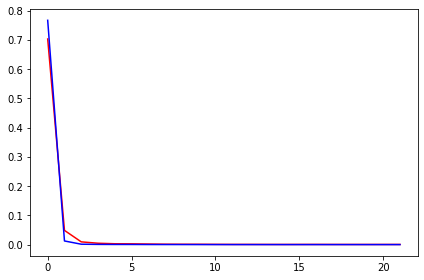

In [13]:
loss = model_nn.history.history['loss']
val_loss = model_nn.history.history['val_loss']

plt.plot(loss,'r-')
plt.plot(val_loss,'b-')
plt.tight_layout()

In [14]:
pred = model_nn.predict(x_test_)
accuracy = np.round(sum(1*(pred.argmax(-1) == y_test))/len(y_test),4)
print(accuracy)

1.0


## Testing Files

In [15]:
%%time
""" 簡體轉換成繁體  """
convertor = OpenCC('s2tw')

path_folder = 'C:\\Users\\CHUSHENGTAN\\Desktop\\chinese_news_dataset\\test\\'

TEXT = []
for folder in os.listdir(path_folder):
    path_subfolder = path_folder + '\\' + folder
    text = []
    for file in os.listdir(path_subfolder):
        path_file = path_subfolder + '\\' + file
        text.append(
            convertor.convert(
                re.sub('http:[/\w.]*','',re.sub('\s','',open(path_file,encoding='utf-8').read()))
            )
        )
    TEXT.append(text)

Wall time: 10.4 s


In [16]:
%%time
"""
## 提取 top-10 的 tf-idf 結果
"""
Jieba_Result = []
for n_category in range(len(TEXT)):
    jieba_result = []
    for n_files in range(len(TEXT[n_category])):
        result = list(jieba.cut_for_search(TEXT[n_category][n_files]))
        result = jieba.analyse.extract_tags(re.sub('\d*','',''.join(result)),topK = 10)
        jieba_result.append([t for t in result if t not in stopWords])
    Jieba_Result.append(jieba_result)
Jieba_Result = sum(Jieba_Result,[]) 


# dictionary = corpora.Dictionary(Jieba_Result)
corpus = [dictionary.doc2bow(text) for text in Jieba_Result]
model = models.TfidfModel(corpus)
corpus_tfidf = [text for text in model[corpus]]

X = gensim.matutils.corpus2dense(corpus_tfidf,num_terms=len(dictionary.token2id)).T#統合起來一起看
X_pred = tf.expand_dims(tf.convert_to_tensor(X),axis=1) 

Wall time: 15.6 s


In [18]:
pred = model_nn.predict(X_pred).argmax(-1)
y = [[category]*len(TEXT[idx]) for idx,category in enumerate(os.listdir(path_folder))] 
y = sum(y,[])
print(sum(1*(le.inverse_transform(pred) == y))/len(y))

0.6685


## Discussions

In [19]:
np.where(le.inverse_transform(pred) != y)#找出哪裡跟test不一 樣

(array([  16,   23,   27,   31,   33,   40,   71,  134,  141,  146,  158,
         191,  203,  243,  325,  328,  372,  379,  411,  421,  483,  492,
         497,  515,  523,  535,  553,  565,  568,  585,  651,  786,  800,
         855,  885,  902,  964,  965, 1041, 1060, 1067, 1076, 1108, 1120,
        1143, 1165, 1166, 1171, 1187, 1191, 1199, 1215, 1268, 1292, 1295,
        1307, 1335, 1348, 1371, 1372, 1377, 1380, 1397, 1400, 1401, 1402,
        1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413,
        1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424,
        1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435,
        1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446,
        1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457,
        1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468,
        1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479,
        1480, 1481, 1482, 1483, 1484, 

In [20]:
pred[16] #先看看第16

2

In [21]:
Jieba_Result[16]

['寧波', '志願', '願者', '志願者', '交通', '記者', '市民', '活動', '交通規則', '一邊']

In [22]:
y[16] #跟體育完全沒關係

'0體育'